# Basic preparations

In this Notebook, the geospatial fabric for the "Nelson Churchill River Basin" gauge is extracted from the `MERIT-Basins` dataset.

If you are using Graham HPC, and have access to Clark's Research Group allocation (`rrg-mclark`), you may find `MERIT-Basins` layers under the following path:</br>
`/project/rrg-mclark/data/geospatial-data/MERIT-Basins/`

If you are using Graham HPC, and have access to Global Water Futures Observatories allocation (`rpp-kshook`), you may find `MERIT-Basins` layers under the following path:</br>
`/project/rpp-kshook/Climate_Forcing_Data/geospatial-data/MERIT-Basins`

The version used is `MERIT_Hydro_v07_Basins_v01_bugfix1` which is a directory under the root directory of the dataset.

Let's get started with our workflow and import necessary Python libraries:

In [1]:
import geopandas as gpd # version 0.14.0

In [3]:
import pandas as pd # version 1.4.0
import numpy as np # version 1.22.2
import matplotlib.pyplot as plt # version 3.5.1
from shapely.geometry import Point # version 2.0.1
import hydrant.topology.geom as gm # version 0.1.0-dev1
import subprocess # built-in Python 3.10.2
import os # built-in Python 3.10.2
import glob # built-in Python 3.10.2

In [ ]:
gm.

`Hydrant` is important in this Notebook. We are only using the `topology.geom`etry module.

Path definitions (system dependant - modify accordingly):

In [4]:
# geofabric paths
merit_basins_root_path = '/project/6008034/Climate_Forcing_Data/geospatial-data/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1'
merit_basins_geom_path = os.path.join(merit_basins_root_path, 'pfaf_level_02')
merit_basins_nca_path = os.path.join(merit_basins_root_path, 'coastal_hillslopes')
# output paths
output_path = '/home/fuaday/github-repos/nelson-churchill/ncrb-geofabric/1-geofabric'
bs_path = '/home/fuaday/github-repos/nelson-churchill/NCRB_shapefiles/NCRB_SubbasinsDissolved.shp'
nctr_test = '/home/fuaday/github-repos/nelson-churchill/NCRB_shapefiles/non.shp' #ncontr_test.shp
nctr_testout = '/home/fuaday/github-repos/nelson-churchill/NCRB_shapefiles/ncontr_test2.shp'

In [5]:
ncrb = pd.concat([gpd.read_file(f).to_crs(epsg=4326) for f in glob.glob(bs_path)])

In [6]:
files = glob.glob(nctr_test)

# Load files, set CRS, and concatenate
gdfs = []
for f in files:
    gdf = gpd.read_file(f)
    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)
    gdfs.append(gdf.to_crs(epsg=4326))
ncrb_nca = pd.concat(gdfs)

In [6]:
print(ncrb.columns)

Index(['MAJ_BAS', 'Shape_Leng', 'Shape_Area', 'geometry'], dtype='object')


<AxesSubplot:>

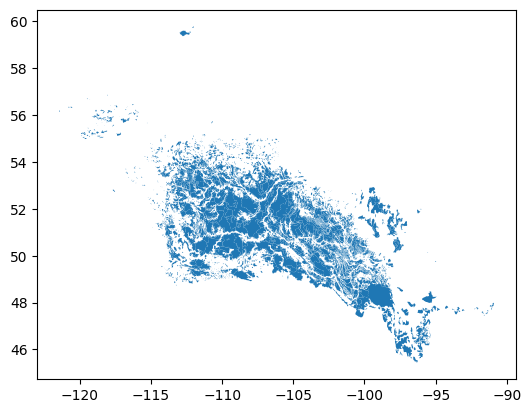

In [7]:
ncrb_nca.plot()

# Reading `MERIT-Basins` Geospatial Fabric Dataset

Upon **visual** inspection (you may use `QGIS` or similar programs), layer #71 has been identified to include necessary sub-basins for ncrb

As you may see in the cell below, we are using Python `list`s to enable reading multiple layers at once. There are cases where a basin of interest is shared between multiple `pfaf` layers.

For now, let's read the files, one by one:

In [7]:
# file names
# catchments (subbasin)
cat_files = [
    'cat_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp',
]
# rivers (river segments)
riv_files = [
    'riv_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp',
]
# non-contributing catchments (those without any river segments defined for them)
nca_files = [
    'hillslope_71_clean.shp',
]

# reading in data in an iterative manner
cat = pd.concat([gpd.read_file(os.path.join(merit_basins_geom_path, f)) for f in cat_files])
riv = pd.concat([gpd.read_file(os.path.join(merit_basins_geom_path, f)) for f in riv_files])
nca = pd.concat([gpd.read_file(os.path.join(merit_basins_nca_path, f)) for f in nca_files])

Since `MERIT-Basins` layers do not come with correct Coordinate Reference System (CRS) information, we need to specify this manually. The `EPSG` code for the `MERIT-Basins` layer is `4326`. Please refer to the following for more information: https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset

In [8]:
# specifying epsg:4326 for all the MERIT-Basins layers
cat.set_crs(epsg=4326, inplace=True)
nca.set_crs(epsg=4326, inplace=True)
riv.set_crs(epsg=4326, inplace=True)

# Show the EPSG of all geospatial layers
print(f'`cat` CRS: {cat.crs}')
print(f'`riv` CRS: {riv.crs}')
print(f'`nca` CRS: {nca.crs}')

`cat` CRS: epsg:4326
`riv` CRS: epsg:4326
`nca` CRS: epsg:4326


In [9]:
# Printing the sizes
print("Size of catchments (cat):", cat.shape)
print("Size of rivers (riv):", riv.shape)
print("Size of non-contributing areas (nca):", nca.shape)

Size of catchments (cat): (48951, 3)
Size of rivers (riv): (48951, 16)
Size of non-contributing areas (nca): (1736, 2)


In [10]:
# Display the headers of each DataFrame
print("Header for Catchments (cat):")
print(cat.head())

print("\nHeader for Rivers (riv):")
print(riv.head())

print("\nHeader for Non-Contributing Areas (nca):")
print(nca.head())

Header for Catchments (cat):
      COMID    unitarea                                           geometry
0  71000092   26.791342  POLYGON ((-102.34292 59.01875, -102.33958 59.0...
1  71007360  104.730245  POLYGON ((-100.10875 57.05625, -100.10458 57.0...
2  71011339   39.055418  POLYGON ((-98.47625 56.06708, -98.47542 56.067...
3  71022453   54.029718  MULTIPOLYGON (((-106.43792 51.97125, -106.4370...
4  71028389   40.749747  POLYGON ((-104.60042 51.00625, -104.59792 51.0...

Header for Rivers (riv):
      COMID   lengthkm  lengthdir  sinuosity     slope      uparea  order  \
0  71000001   7.020492   4.158236   1.688334  0.000570  391.901537      2   
1  71000002  24.171249  15.709184   1.538670  0.000058  701.754912      2   
2  71000003  14.760464  11.209022   1.316838  0.000770  480.760660      2   
3  71000004   6.240078   4.631999   1.347168  0.000911  388.938962      2   
4  71000005   4.462477   3.338111   1.336827  0.000670  328.557527      2   

   strmDrop_t  slope_taud  NextD

# Preparing `cat`, `riv`, and `nca` objects for `NCRB`

## Preparing `MERIT-Basins` Layers

Before subsetting the entire layer #71 of the `MERIT-Basins` dataset, we have to assure the layers are ready to be further processed by the `Hydrant` package. Fortunately, `Hydrant` provides necessary functionalities to work with this specific geospatial fabric (applicable to any geospatial fabric in reality). 

In doing so, Hydrant's `geom` module provides the `prepare_cat(...)` function to prepare the `MERIT-Basins` geosptial fabric's sub-basins (or catchments) for the next post-processing steps. Please note that since the non-contributing areas (`nca`) are technically considered sub-basins, they are taken care of using this functionality of `Hydrant`:

In [11]:
# Hydrant's `geom` module provides the `prepare_cat`
# function to prepare the `MERIT-Basins` geosptial
# fabric for next post-processing steps

catchments = gm.prepare_cat(
    cat=cat, # 
    cat_col_id='COMID',
    cst=nca,
    cst_col_mapper={'FID':'COMID'},
    cst_col_id='COMID'
)

# You may see the "docstring" of the `gm.prepare_cat`
# function by running:
# >>> gm.prepare_cat?
# in a separate Jupyter cell (without the >>>), or by
# running simply:
# >>> print(gm.prepare_cat.__doc__)

In [12]:
# added from smm example

# first, creating the directory
try:
    os.makedirs(output_path)
except FileExistsError:
    pass
catchments.to_file(os.path.join(output_path, 'NCRB_catchmentsTest.shp'))

Similarly, the `geom` module provides the `prepare_riv(...)` function to prepare the `MERIT-Basins` geospatial fabric's river segments for the next post-processing steps:

In [13]:
# Similarly, the `geom` module provides the
# `prepare_riv` function to prepare the `MERIT-Basins`
# geospatial fabric's river segments for the next
# post-processing steps:

rivers = gm.prepare_riv(
    riv=riv,
    riv_cols={
        'id':'COMID',
        'next_id':'NextDownID',
        'slope':'slope',
        'length':'lengthkm',
        'length_direct':'lengthdir'
    },
    cat=catchments,
    cat_cols={
        'id':'COMID',
        'hillslope':'hillslope',
        'geom':'geometry'
    }
)

# You may see the "docstring" of the `gm.prepare_riv`
# function by running:
# >>> gm.prepare_riv?
# in a separate Jupyter cell (without the >>>), or by
# running simply:
# >>> print(gm.prepare_riv.__doc__)

In Python, you may always access the "docstring" documentations for the functions and classes by running:
```python
>>> print(func.__doc__)
```
Or, if you are working in the Jupyter environment, you may simply run the following in a separate Jupyter cell:
```ipython
[ln1] func?
```
If you are interested in reading up on the functionality of each function used above, use the mentioned methods to print the "docstrings".

Therefore, if you would like to read up on the `gm.prepare_cat(...)` or `gm.prepare_riv(...)` functionality, simply uncomment and execute the following cell:

In [15]:
def assign_intersection_flag_gdf(
    gdf1: gpd.GeoDataFrame,
    gdf2: gpd.GeoDataFrame,
    output_path: str = None
) -> gpd.GeoDataFrame:
    """
    Assigns a flag to polygons in the first GeoDataFrame based on intersection with polygons in the second GeoDataFrame.

    Parameters
    ----------
    gdf1 : gpd.GeoDataFrame
        The first GeoDataFrame.
    gdf2 : gpd.GeoDataFrame
        The second GeoDataFrame.
    output_path : str, optional
        Path where the modified first GeoDataFrame should be saved. If None, the file is not saved.

    Returns
    -------
    gpd.GeoDataFrame
        The modified GeoDataFrame of the first GeoDataFrame with the 'ncontr' column added.
    """
    # Initialize the 'ncontr' column to 0 for all rows in gdf1
    #gdf1['ncontr'] = 0
    
    # Update 'ncontr' to 1 for polygons in gdf1 that intersect with any polygon in gdf2
    for index, row in gdf1.iterrows():
        if gdf2['geometry'].intersects(row['geometry']).any():
            gdf1.at[index, 'hillslope'] = 1
            
    # Save the modified gdf1 to a new shapefile if an output path is provided
    if output_path is not None:
        gdf1.to_file(output_path)
    
    return gdf1

In [16]:
import geopandas as gpd

def assign_intersection_flag_gdf_threshold(
    gdf1: gpd.GeoDataFrame,
    gdf2: gpd.GeoDataFrame,
    threshold: float = 0.1,  # Threshold set to 10% by default
    output_path: str = None
) -> gpd.GeoDataFrame:
    """
    Assigns a flag to polygons in the first GeoDataFrame based on significant intersection
    (defined by a threshold) with polygons in the second GeoDataFrame.

    Parameters
    ----------
    gdf1 : gpd.GeoDataFrame
        The first GeoDataFrame.
    gdf2 : gpd.GeoDataFrame
        The second GeoDataFrame.
    threshold : float, optional
        The threshold for considering an intersection significant, as a fraction of
        the first GeoDataFrame's polygon area (default is 0.1 for 10%).
    output_path : str, optional
        Path where the modified first GeoDataFrame should be saved. If None, the file is not saved.

    Returns
    -------
    gpd.GeoDataFrame
        The modified GeoDataFrame of the first GeoDataFrame with the 'ncontr' column added.
    """
    # Initialize the 'ncontr' column to 0 for all rows in gdf1
    gdf1['ncontr'] = 0
    
    # Iterate over gdf1 to check for significant intersections with gdf2
    for index1, row1 in gdf1.iterrows():
        for index2, row2 in gdf2.iterrows():
            if row1['geometry'].intersects(row2['geometry']):
                # Calculate the area of the intersection
                intersection_area = row1['geometry'].intersection(row2['geometry']).area
                # Calculate the fraction of row1's area that is covered by the intersection
                area_fraction = intersection_area / row1['geometry'].area
                # Check if the fraction exceeds the threshold
                if area_fraction > threshold:
                    gdf1.at[index1, 'ncontr'] = 1
                    # Once a significant intersection is found, no need to check more polygons for this row
                    break
            
    # Save the modified gdf1 to a new shapefile if an output path is provided
    if output_path is not None:
        gdf1.to_file(output_path)
    
    return gdf1

In [14]:
import geopandas as gpd

def assign_intersection_flag_gdf_sindex(
    gdf1: gpd.GeoDataFrame,
    gdf2: gpd.GeoDataFrame,
    threshold: float = 0.1,  # Threshold set to 10% by default
    output_path: str = None
) -> gpd.GeoDataFrame:
    """
    Efficiently assigns a flag to polygons in the first GeoDataFrame based on significant intersection
    (defined by a threshold) with polygons in the second GeoDataFrame using spatial indexing.

    Parameters
    ----------
    gdf1 : gpd.GeoDataFrame
        The first GeoDataFrame.
    gdf2 : gpd.GeoDataFrame
        The second GeoDataFrame.
    threshold : float, optional
        The threshold for considering an intersection significant, as a fraction of
        the first GeoDataFrame's polygon area (default is 0.1 for 10%).
    output_path : str, optional
        Path where the modified first GeoDataFrame should be saved. If None, the file is not saved.

    Returns
    -------
    gpd.GeoDataFrame
        The modified GeoDataFrame of the first GeoDataFrame with the 'ncontr' column added.
    """
    # Initialize the 'ncontr' column to 0 for all rows in gdf1
    gdf1['ncontr'] = 0
    
    # Create spatial index for gdf2
    spatial_index = gdf2.sindex
    
    # Iterate over gdf1 using spatial indexing to find potential intersections
    for index, row in gdf1.iterrows():
        # Use spatial index to find potential intersections
        possible_matches_index = list(spatial_index.query(row['geometry'], predicate='intersects'))
        if not possible_matches_index:
            continue  # No intersections, move to next row
        
        # Filter possible matches for actual intersection
        possible_matches = gdf2.iloc[possible_matches_index]
        actual_intersections = possible_matches[possible_matches.intersects(row['geometry'])]
        
        # Calculate area fractions for actual intersections
        for _, match in actual_intersections.iterrows():
            intersection_area = row['geometry'].intersection(match['geometry']).area
            area_fraction = intersection_area / row['geometry'].area
            if area_fraction > threshold:
                gdf1.at[index, 'ncontr'] = 1
                break  # Break after finding the first significant intersection
    
    # Save the modified gdf1 to a new shapefile if an output path is provided
    if output_path is not None:
        gdf1.to_file(output_path)
    
    return gdf1

In [22]:
modified_gdf = assign_intersection_flag_gdf(catchments, ncrb_nca, nctr_testout)

# If you wish to view the first few rows of the modified GeoDataFrame
##print(modified_gdf.head())

In [ ]:
modified_gdf = assign_intersection_flag_gdf_threshold(catchments, ncrb_nca,0.2, nctr_testout)

In [16]:
modified_gdf = assign_intersection_flag_gdf_sindex(catchments, ncrb_nca,0.3, nctr_testout)

In [18]:
#gm.prepare_cat?

In [ ]:
# gm.prepare_riv?

In [19]:
# ADDED from smm example
ncrb_catchments, ncrb_rivers = gm.intersect_topology(
    cat=modified_gdf,
    cat_cols={
        'id':'COMID'
    },
    riv=rivers,
    riv_cols={
        'id':'COMID',
        'next_id':'NextDownID'
    },
    shapefile=ncrb)

In [20]:
# # ADDED from smm example
# ncrb_catchments, ncrb_rivers = gm.intersect_topology(
#     cat=catchments,
#     cat_cols={
#         'id':'COMID'
#     },
#     riv=rivers,
#     riv_cols={
#         'id':'COMID',
#         'next_id':'NextDownID'
#     },
#     shapefile=ncrb)

In [21]:
ncrb_catchments

,COMID,unitarea,geometry,hillslope
21,71000022,29.205639,"POLYGON ((-101.78625 59.10708, -101.78375 59.1...",0
22,71000023,27.179038,"POLYGON ((-101.83792 59.11875, -101.83375 59.1...",0
23,71000024,7.862929,"POLYGON ((-101.91042 59.05458, -101.90792 59.0...",0
24,71000025,53.969083,"POLYGON ((-101.98125 59.01292, -101.97708 59.0...",0
25,71000026,28.626667,"POLYGON ((-101.92208 59.09042, -101.91958 59.0...",0
...,...,...,...,...
48948,71048949,76.116685,"MULTIPOLYGON (((-97.83125 46.00875, -97.82542 ...",0
48949,71048950,43.278839,"POLYGON ((-96.07708 46.00542, -96.07625 46.005...",0
48950,71048951,69.279829,"MULTIPOLYGON (((-96.65292 45.93542, -96.65208 ...",0
50685,71050686,10.810153,"POLYGON ((-108.54708 52.72625, -108.54625 52.7...",1


<AxesSubplot:>

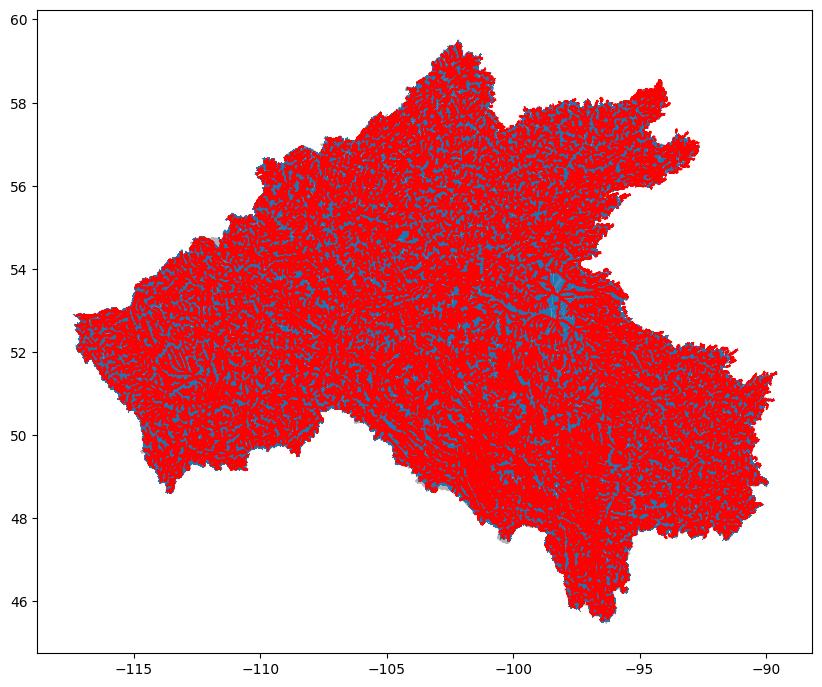

In [23]:
ax = ncrb.plot(color='black', alpha=0.3, figsize=(10, 20))
ncrb_rivers.plot(ax=ax, color='red')
ncrb_catchments.plot(ax=ax)

Now, let's plot what have extracted from the larger `MERIT-Basins` geospatial fabric:

<AxesSubplot:>

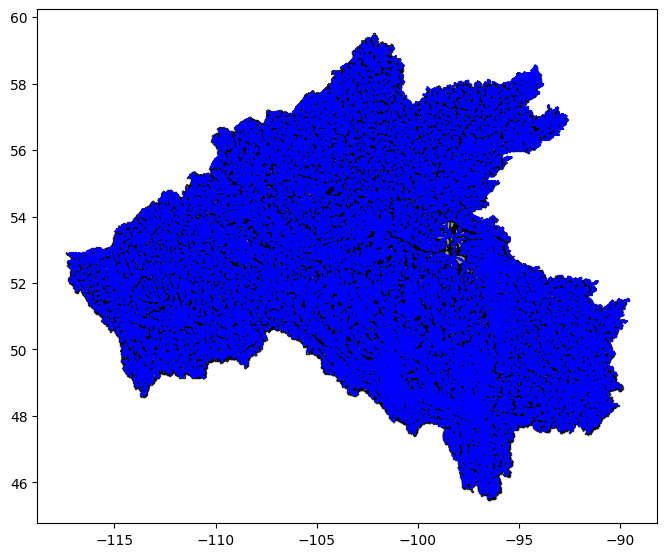

In [24]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 8)
)

# sub-basins
ncrb_catchments.plot(ax=ax, color='gray', edgecolor='black', alpha=0.8, zorder=1)
# river segments
ncrb_rivers.plot(ax=ax, color='blue', alpha=1, zorder=2)
# gauge location
# ax.scatter(point.x, point.y, color='red', alpha=0.8, zorder=3)

# Saving Extracted Geospatial Fabric upstream of Bow River at Banff Hydrometric Station

In [25]:
# saving the results into the `output_path` directory

# first, creating the directory
try:
    os.makedirs(output_path)
except FileExistsError:
    pass

# then, saving the data
ncrb_catchments.to_file(os.path.join(output_path, 'ncrb_subbasins.shp'))
ncrb_rivers.to_file(os.path.join(output_path, 'ncrb_rivers.shp'))

___

If you face any issues, e-mail [kasra.keshavarz1 AT ucalgary DOT ca](mailto:kasra.keshavarz1@ucalgary.ca).